In [6]:
import graphinglib as gl
from astropy.io import fits
import numpy as np
import scipy
import pyregion
import dill
from functools import partial
import time
from eztcolors import Colors as C
from tqdm import tqdm
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))      # fixes jupyter notebook imports

from src.tools.zurflueh_filter.zfilter import zfilter
from src.tools.statistics.advanced_stats import autocorrelation_function, autocorrelation_function_2d, \
    get_autocorrelation_function_2d_contour, structure_function, evaluate_delta_f2
from src.hdu.maps.map import Map
from src.hdu.arrays.array_2d import Array2D
from src.tools.mask import Mask

# Early tests

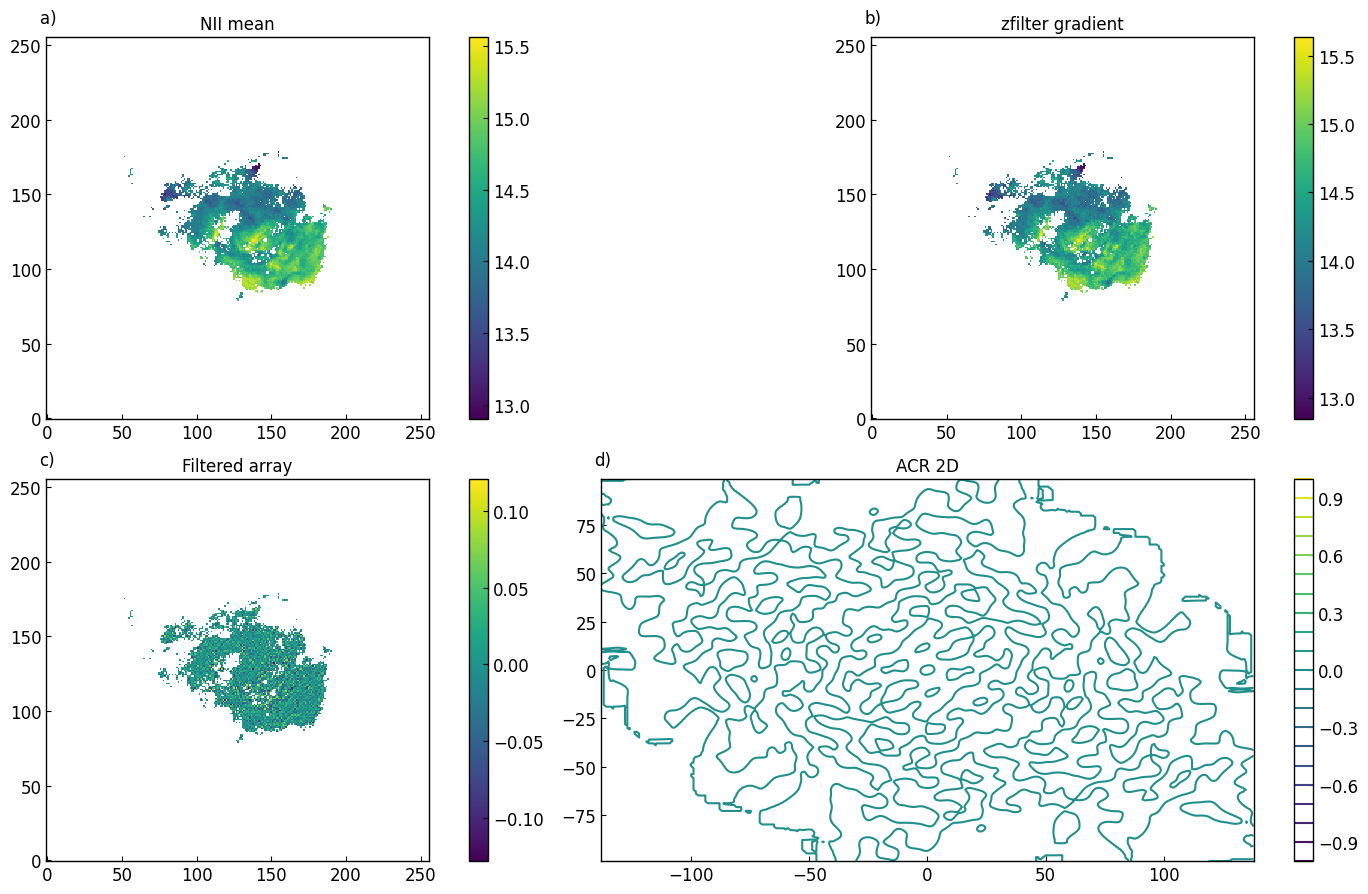

In [27]:
m = Map.load("summer_2023/gaussian_fitting/maps/computed_data/NII_mean.fits")
mask = fits.open("summer_2023/gaussian_fitting/maps/computed_data/NII_fwhm.fits")[2].data
masked = Map(np.where(mask > 10, m.data, np.NAN)).bin((2,2))

fig1 = gl.Figure(title="NII mean", size=(10, 7))
fig1.add_elements(masked.data.plot)
# fig1.show()

gradient = zfilter(masked.data, pixel_width=3)

fig2 = gl.Figure(title="zfilter gradient", size=(10, 7))
fig2.add_elements(gl.Heatmap(gradient, origin_position="lower", color_map="viridis"))
# fig2.show()

fig3 = gl.Figure(title="Filtered array", size=(10, 7))
fig3.add_elements(gl.Heatmap(masked.data - gradient, origin_position="lower", color_map="viridis"))
# fig3.show()

fig4 = gl.Figure(title="ACR 2D", size=(10, 7))
fig4.add_elements(get_autocorrelation_function_2d_contour(autocorrelation_function_2d(masked.data - gradient)))
# fig4.show()

multifig = gl.MultiFigure.from_grid([fig1, fig2, fig3, fig4], (2,2), size=(16,9))
multifig.show()
# multifig.save("figures/sh158/advanced_stats/autocorrelation/nii_mean.pdf")

In [4]:
data = autocorrelation_function_2d(masked.data - gradient)
# np.savetxt("t.txt", data)

data = np.append(
    data,
    data * np.tile((-1, -1, 1), (data.shape[0], 1)),
    axis=0
)

x_lim = np.min(data[:,0]), np.max(data[:,0])
y_lim = np.min(data[:,1]), np.max(data[:,1])

x_grid, y_grid = np.meshgrid(np.arange(x_lim[0], x_lim[1] + 1), 
                                np.arange(y_lim[0], y_lim[1] + 1))

z_data = np.zeros_like(x_grid)
for x, y, z in data:
    z_data[int(y-np.min(data[:,1])), int(x-np.min(data[:,0]))] = z
z_data = scipy.ndimage.gaussian_filter(z_data, 3)

contour = gl.Contour(
    x_mesh=x_grid,
    y_mesh=y_grid,
    z_data=z_data,
    show_color_bar=True,
    number_of_levels=list(np.arange(-1, 1 + 0.1, 0.001)),
    filled=False,
    color_map="viridis",
)

fig = gl.Figure()
fig.add_elements(contour)
fig.show()


NameError: name 'masked' is not defined

# Relevant figures

In [7]:
from scipy.optimize import curve_fit


def power_function(x, a, m):
    return a * x**m

def estimate_params(data, number_of_iterations: int=1000):
    sample_data = np.array([np.random.normal(mu, abs(sigma), number_of_iterations) for mu, sigma in data[:,1:3]])
    parameters = []
    for i in range(number_of_iterations):
        parameters.append(curve_fit(power_function, data[:,0], sample_data[:,i], [0.3, 0.5], maxfev=100000)[0])
    
    parameters_array = np.array(parameters)
    results = {
        "a": np.array([np.mean(parameters_array[:,0]), np.std(parameters_array[:,0])]),
        "m": np.array([np.mean(parameters_array[:,1]), np.std(parameters_array[:,1])]),
    }
    return results

def get_plottables(data: np.ndarray, region_radius: float, measure: str="acr") -> list:
    sorted_data = data[np.argsort(data[:,0])]
    scatter = gl.Scatter(
        sorted_data[:,0],
        sorted_data[:,1],
        marker_size=3,
        face_color="black",
    )

    scatter.add_errorbars(
        y_error=np.abs(sorted_data[:,2]),
        errorbars_line_width=0.25,
        cap_width=0,
    )

    curve = gl.Curve(scatter.x_data, scatter.y_data)
    intersections = curve.get_intersection_coordinates(curve * 0)
    annotations = [
        gl.Point(inte[0], inte[1], label=f"({inte[0]:.2f},{inte[1]:.2f})", color="red", marker_size=7, h_align=loc)
        for inte, loc in zip(intersections[:2], ["right", "left"])
    ]

    if measure == "str":
        mask = (sorted_data[:,0] <= region_radius)
        pm = estimate_params(sorted_data[mask], 10000)
        fit = gl.Curve.from_function(
            func=partial(power_function, a=pm["a"][0], m=pm["m"][0]),
            x_min=0,
            x_max=region_radius,
            label=rf"Slope : {pm["m"][0]:.3f} ± {pm["m"][1]:.3f}",
            line_width=1,
            color="red",
        )
        return [scatter, fit]
    else:
        return [scatter, *annotations]

regions = [
    ("Global region", None, 50),
    ("Diffuse region", pyregion.open("summer_2023/gaussian_fitting/regions/region_1.reg"), 20),
    ("Central region", pyregion.open("summer_2023/gaussian_fitting/regions/region_2.reg"), 10),
    ("Filament region", pyregion.open("summer_2023/gaussian_fitting/regions/region_3.reg"), 6)
]

In [8]:
def create_4_plot_acr_figure(map_: Map, filename: str, measure: str="acr"):
    if measure == "acr":
        function = lambda data: autocorrelation_function(data, method="Boily")
    elif measure == "str":
        function = lambda data: structure_function(data)
    else:
        raise ValueError("invalid measure. Should be either 'acr' or 'str'.")
    
    figs = []

    for name, region, region_radius in regions:
        if not region:
            try:
                with open(f"figures/sh158/nii_mean/dill/{filename}.gz", "rb") as f:
                    data = dill.load(f)
            except:
                data = function(map_.get_masked_region(region).data)
                with open(f"figures/sh158/nii_mean/dill/{filename}.gz", "wb") as f:
                    dill.dump(data, f)
        else:
            data = function(map_.get_masked_region(region).data)

        fig = gl.Figure(
            title=name,
            x_lim=(0, region_radius*1.2),
        )
        plottables = get_plottables(data, region_radius, measure)
        cropped_scatter = plottables[0].create_slice_x(0, region_radius*1.2)
        fig.y_lim = np.min(cropped_scatter.y_data)-0.2, np.max(cropped_scatter.y_data)+0.3
        fig.add_elements(*plottables)
        figs.append(fig)

    multifig = gl.MultiFigure.from_grid(figs, (2,2), (13, 8.6))
    multifig.x_label = "Lag [pixels]"
    multifig.y_label = "Autocorrelation Function [-]"
    multifig.save(f"figures/sh158/nii_mean/{filename}.pdf")

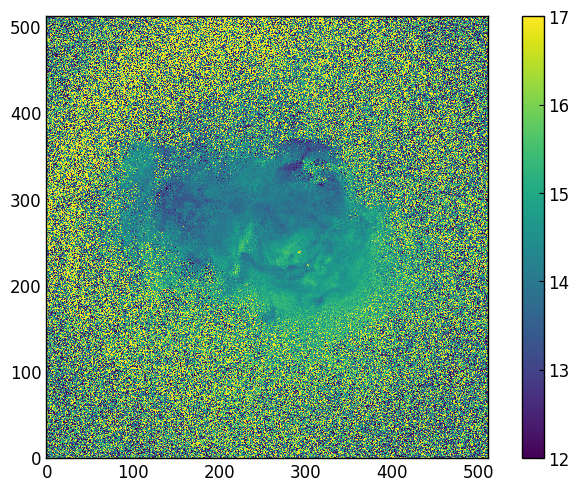

NameError: name 'create_4_plot_acr_figure' is not defined

In [4]:
r = Map.load("summer_2023/gaussian_fitting/maps/computed_data/turbulence.fits")
m = Map.load("summer_2023/gaussian_fitting/maps/computed_data/nii_mean.fits")
masked = m.get_masked_region(pyregion.open("data/sh158_article/target_region.reg"))
gradient = zfilter(masked.data)
filtered_map = Map(masked.data - gradient, masked.uncertainties, masked.header)
fig = gl.Figure(); fig.add_elements(m.data.plot); fig.show()
# create_4_plot_acr_figure(filtered_map, "acr_selective_nii", "acr")
create_4_plot_acr_figure(masked, "acr_selective_nii_nz", "acr")
# create_4_plot_acr_figure(masked, "str_selective_nii_nz", "str")
# create_4_plot_acr_figure(filtered_map, "str_selective_nii", "str")
# fig = gl.Figure()
# fig.add_elements(get_autocorrelation_function_2d_contour(autocorrelation_function_2d(masked.data)))
# fig.save("figures/sh158/nii_mean/acr_selective_nii_2d_unfiltered.pdf")

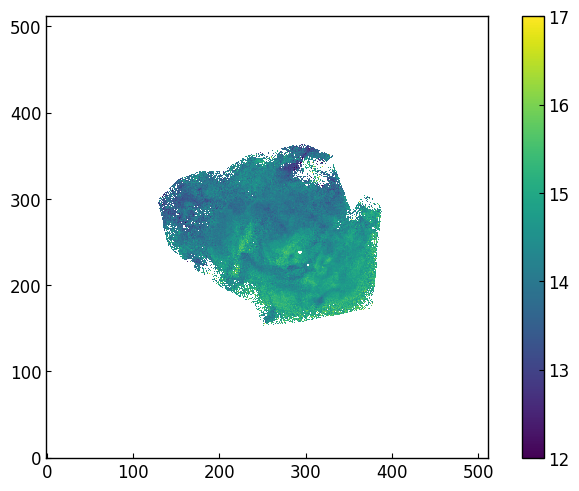

In [9]:
m = Map.load("summer_2023/gaussian_fitting/maps/computed_data/nii_mean.fits")
masked_0 = m.get_masked_region(pyregion.open("data/sh158_article/target_region.reg"))
mask = fits.open("summer_2023/gaussian_fitting/maps/computed_data/NII_fwhm.fits")[2].data       # opens the SNR map
masked = Map(
    np.where(mask > 5, masked_0.data, np.NAN),
    np.where(mask > 5, masked_0.uncertainties, np.NAN),
    masked.header
)
fig = gl.Figure(); fig.add_elements(masked.data.plot); fig.show()

gradient = zfilter(masked.data)
filtered_map = Map(masked.data - gradient, masked.uncertainties, masked.header)
create_4_plot_acr_figure(filtered_map, "acr_snr_over_5_nii", "acr")

# Test Zurflueh on NII_FWHM

In [ ]:
m_fwhm = Map.load("summer_2023/gaussian_fitting/maps/computed_data/NII_fwhm.fits")
figs = [gl.Figure(title=t) for t in ["NII_fwhm", "gradient", "gradient removed"]]
p_0 = m_fwhm.data.plot
p_0._vmin = 0
p_0._vmax = 50
figs[0].add_elements(p_0)
grad = Map(zfilter(m_fwhm.data))
p_1 = grad.data.plot
p_1._vmin = 0
p_1._vmax = 50
figs[1].add_elements(p_1)
p_2 = (m_fwhm-grad).data.plot
p_2._vmin = 0
p_2._vmax = 50
figs[2].add_elements(p_2)

multifig = gl.MultiFigure.from_grid(figs, (1,3), (13,4))
# multifig.show()
multifig.save("figures/zfilter/NII_fwhm.pdf", dpi=600)

### Cross-checking

In [12]:
m = Map.load("summer_2023/gaussian_fitting/maps/computed_data/nii_mean.fits")
masked_0 = m.get_masked_region(pyregion.open("data/sh158_article/target_region.reg")).bin((3,3))

str_func = structure_function(masked_0.data)
acr_func = autocorrelation_function(masked_0.data, method="Boily")

HERE: 0.201455


In [19]:
test_arr = np.array([
    [1,2,4],
    [3,5,4]
])

# acr_func2 = autocorrelation_function(test_arr)
# str_func2 = structure_function(test_arr)

tau = 3

# STR
print(2 * (acr_func[acr_func[:,0] == 0,1] - acr_func[acr_func[:,0] == tau,1]))

from eztcolors import Colors as C
print(C.LIGHT_CYAN+"------"+C.END)

# ACR
print(str_func[str_func[:,0] == tau])

[0.54333714]
------
[[3.         0.46921473 0.01224102]]


In [11]:
str_ = np.nanstd(test_arr)**(-2) * 4**(-1) * ((1-5)**2+(2-3)**2+(2-4)**2+(4-5)**2)
print(str_)
# print(str_func2[str_func2[:,0] == tau])

acr = np.nanstd(test_arr)**(-2) * 4**(-1) * (1*5+2*3+2*4+4*5)
print(acr)
acr_0 = np.nanstd(test_arr)**(-2) * 6**(-1) * (1**2+2**2+4**2+3**2+5**2+4**2)
# print(acr_0)
# print(acr_func2)

print(2*(acr_0-acr))

3.0461538461538464
5.4
2.3076923076923084


# Optimal filter width

In [7]:
m = Map.load("data/sh158/fit_no_bin/NII_mean.fits")
masked = m.get_masked_region(pyregion.open("data/sh158/turb.reg")).bin((2,2))
# fig = gl.Figure()
# fig.add_elements(masked.data.plot)
# fig.show()
# raise

start = time.time()
for width in tqdm(range(3,35,2), total=16, desc="Evaluating"):
    gradient = zfilter(masked.data, pixel_width=width)
    filtered_map = Map(masked.data - gradient, masked.uncertainties, masked.header)
    res = evaluate_delta_f2(filtered_map.data)
    with open("applications/sh158/zfilter_widths.txt", "a") as f: 
        if res:
            f.write(f"width={width:02}, ∆F_2(tau_0)={res}\n")
        else:
            f.write(f"width={width:02}, INVALID\n")
print(C.BROWN+f"All zurflueh filter widths were correctly evaluated in {time.time()-start}s"+C.END)

if False:
    # radiuses = [50, 20, 10, 6]
    gradient = zfilter(masked.data, pixel_width=23)
    filtered_map = Map(masked.data - gradient, masked.uncertainties, masked.header)
    fig = gl.Figure(); fig.add_elements(filtered_map.data.plot); fig.show()
    fig = gl.Figure(); fig.add_elements(gl.Heatmap(gradient, origin_position="lower")); fig.show()
    # acr = autocorrelation_function(filtered_map.data)
    fig = gl.Figure(x_lim=(0,50)); fig.add_elements(gl.Scatter(acr[:,0], acr[:,1], marker_size=1)); fig.show()
    # str_ = structure_function(filtered_map.data)
    fig = gl.Figure(x_lim=(0,50)); fig.add_elements(gl.Scatter(str_[:,0], str_[:,1], marker_size=1)); fig.show()
    # fig = gl.Figure(); fig.add_elements(masked.data.plot); fig.show()
    # fig = gl.Figure(); fig.add_elements(gl.Heatmap(gradient, origin_position="lower")); fig.show()
    # print(f"Width : {width:02}, ∆F2(tau_0) : {evaluate_delta_f2(filtered_map.data, radiuses[0])}")


Evaluating:   0%|          | 0/16 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [4]:
figs = [gl.Figure(x_lim=(0,radiuses[0])) for _ in range(2)]
acr_curve = gl.Curve(acr[:,0], acr[:,1])
str_curve = gl.Curve(str_[:,0], str_[:,1])
[fig.add_elements(element) for fig, element in zip(figs, [acr_curve, str_curve])]
multifig = gl.MultiFigure.from_row(figs, size=(10,5))
%matplotlib tk
multifig.show()

0.09737752933655375


2024-09-20 10:06:36.845 Python[84968:5058506] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/z8/44crt9313mlc559ypygm9ptw0000gn/T/org.python.python.savedState


In [3]:
%matplotlib tk
fig.show()

2024-09-20 10:34:41.982 Python[85998:5081875] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/z8/44crt9313mlc559ypygm9ptw0000gn/T/org.python.python.savedState


In [14]:
from src.hdu.cubes.cube import Cube

cube = Cube.load("summer_2023/gaussian_fitting/data_cubes/night_34_wcs.fits")[:,260:815,60:850]
cube.save("data/sh158/fit_no_bin/night_34_wcs.fits")